## Load Necessary Library

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import cv2
from PIL import Image
import os
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.preprocessing import MinMaxScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.ensemble import RandomForestClassifier
from skimage.feature import local_binary_pattern as LBP

## Load Folder of Image
##### Create a dataset that will return the image, target label of each image and uniqe target name of each person

In [7]:
import ipynb.fs.full.face_main

In [8]:
dataset = load_images('./Data/')

In [9]:
# BACKUP
lfw_dataset = dataset.copy()

# understand about dataset
print("Shape of images:", lfw_dataset['data'].shape)
print("Shape of labels:", lfw_dataset['target'].shape)
print("Unique labels:", lfw_dataset['target_names'].shape)

Shape of images: (13233, 250, 250, 3)
Shape of labels: (13233,)
Unique labels: (5749,)


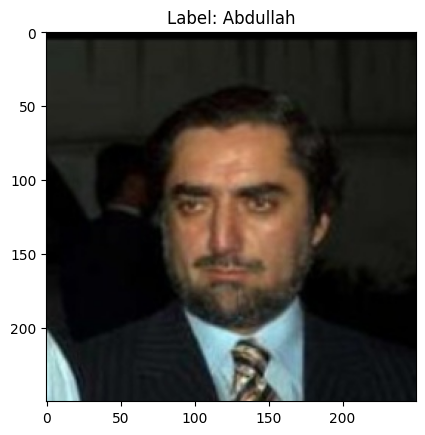

In [10]:
# display an image with its label
first_image = dataset['data'][24]

plt.imshow(first_image)
plt.title(f'Label: {dataset["target"][24]}')
plt.show()

## Data Exploration and Visualization

### Image Distribuition of Top 20 People

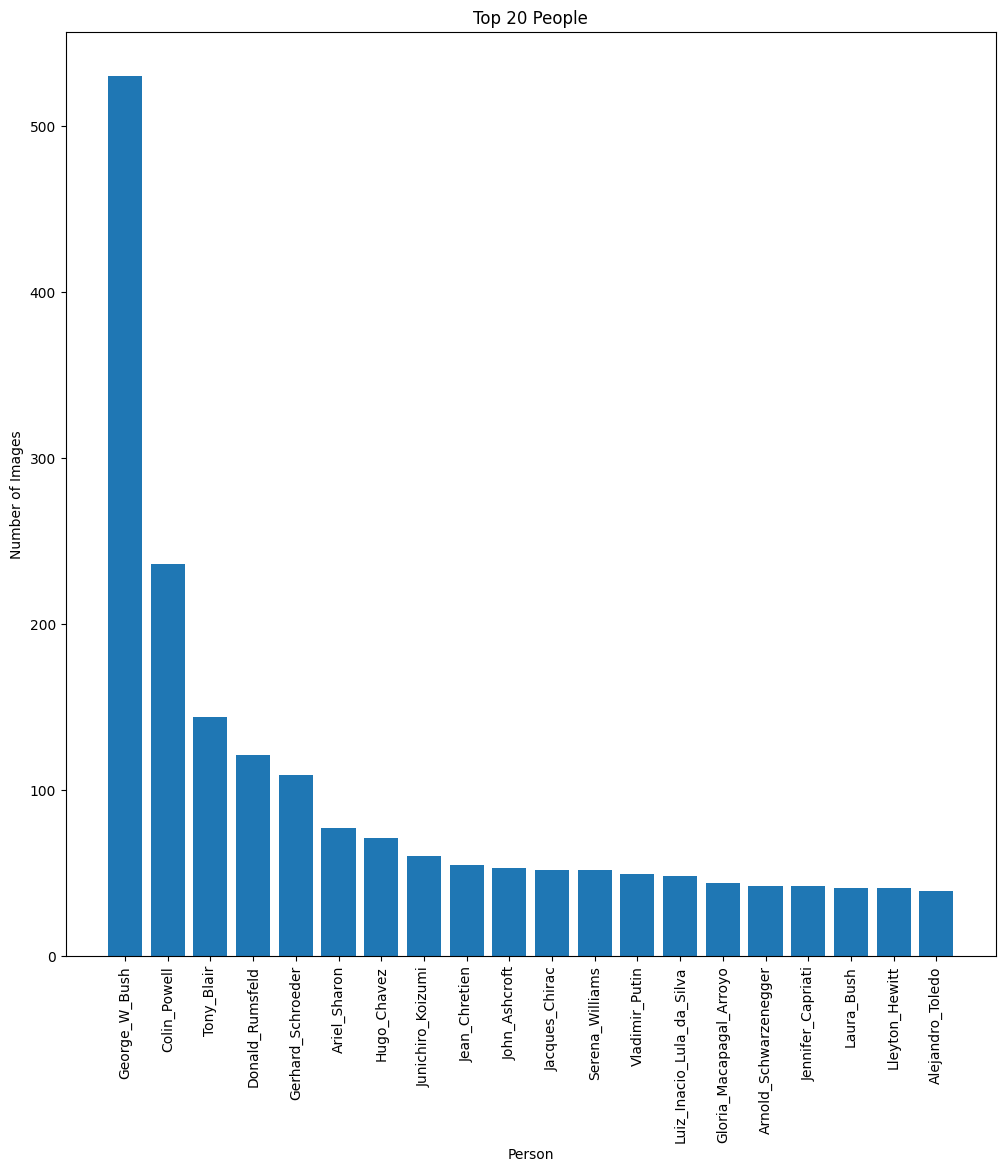

In [11]:
target_counts = Counter(dataset['target'])

top_20_people = target_counts.most_common(20)

plt.figure(figsize=(12, 12))
plt.bar(*zip(*top_20_people))
plt.xlabel('Person')
plt.xticks(rotation=90)
plt.ylabel('Number of Images')
plt.title('Top 20 People')
plt.show()

### Histogram

In [12]:
ranges = [(1, 1), (2, 5), (6, 10), (11, 19), (20, 30), (31, 80), (81, np.inf)]
labels = ['1', '2-5', '6-10', '11-19', '20-30', '31-80', '>81']

people_counts = [0] * len(ranges)
image_counts = [0] * len(ranges)

# For each person, increment the count for the appropriate range
for person, count in target_counts.items():
    for i, (min_count, max_count) in enumerate(ranges):
        if min_count <= count <= max_count:
            people_counts[i] += 1
            image_counts[i] += count
            break

# Calculate the percentages
total_people = sum(people_counts)
total_images = sum(image_counts)
people_percentages = [f"{count / total_people * 100:.2f}" for count in people_counts]
images_percentages = [f"{count / total_images * 100:.2f}" for count in image_counts]

# Create a DataFrame
df = pd.DataFrame({
    '# of images /person': labels,
    '# of people': people_counts,
    '% of people': people_percentages,
    '# of images': image_counts,
    '% of images': images_percentages
})

df

,# of images /person,# of people,% of people,# of images,% of images
0,1,4069,70.78,4069,30.75
1,2-5,1369,23.81,3739,28.26
2,6-10,168,2.92,1251,9.45
3,11-19,81,1.41,1151,8.70
4,20-30,30,0.52,713,5.39
5,31-80,27,0.47,1170,8.84
6,>81,5,0.09,1140,8.61


### Distribuition of Pixel Values

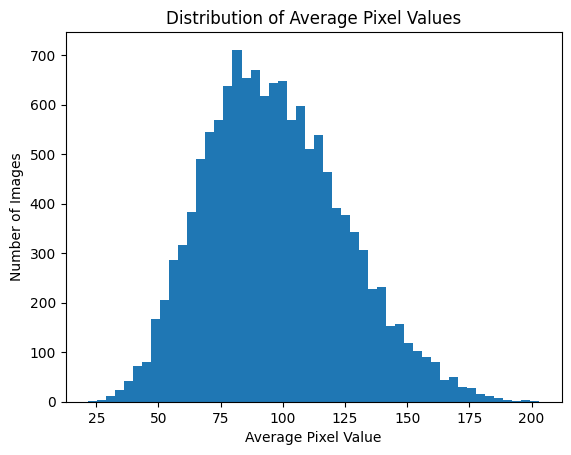

In [13]:
# Distribuition of Pixel Values

# Get the average pixel values for each image
average_pixels = np.mean(dataset['data'], axis=(1, 2, 3))

# Plot the distribution of average pixel values with 50 bins
plt.hist(average_pixels, bins=50)  # Change the number of bins to 50
plt.xlabel('Average Pixel Value')
plt.ylabel('Number of Images')
plt.title('Distribution of Average Pixel Values')

plt.show()

### Plot Some Images

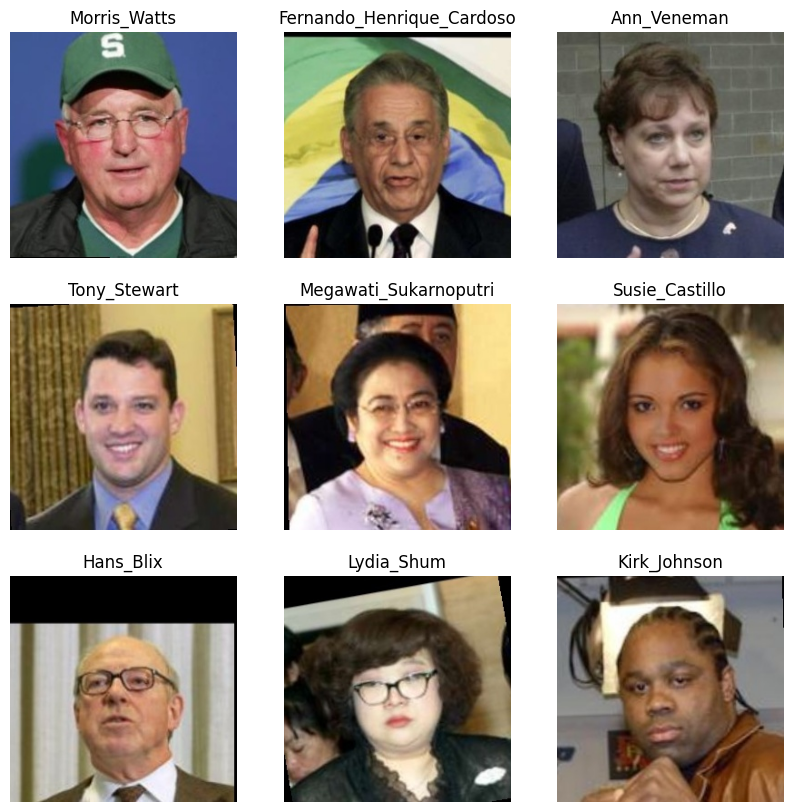

In [14]:
# Function to display a random set of images

def display_random_images(images, labels, rows, cols, cmap=None):
    fig = plt.figure(figsize=(10, 10))

    for i in range(1, cols * rows + 1):
        index = np.random.randint(len(images))
        plt.subplot(rows, cols, i)
        plt.axis('off')
        plt.imshow(images[index], cmap=cmap)
        plt.title(labels[index])

    plt.show()

display_random_images(dataset['data'], dataset['target'], 3, 3)

## Data Preprocessing

### Image Resizing

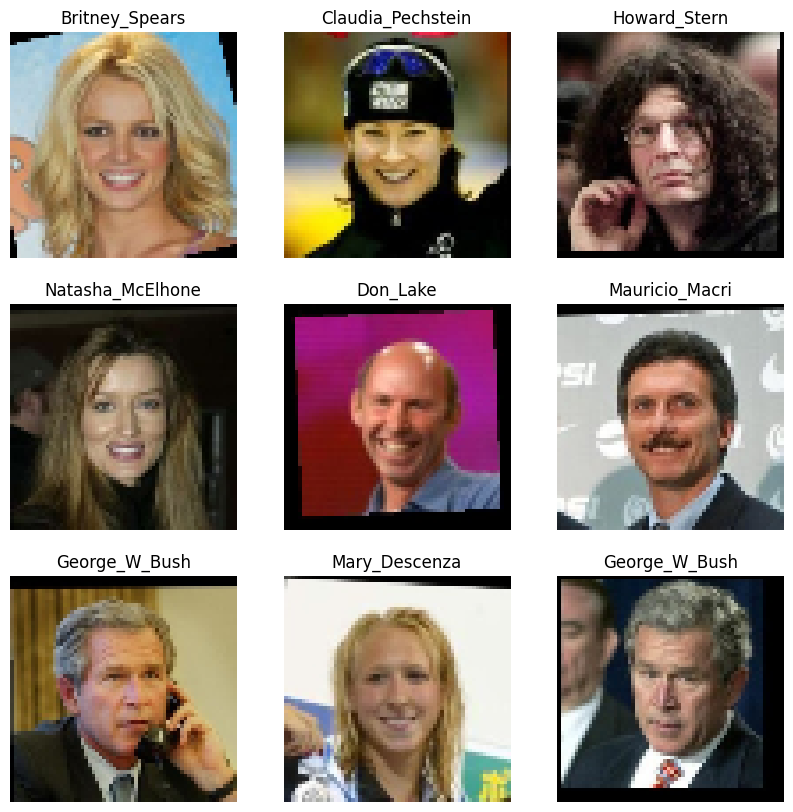

In [16]:
def resize_image(images, target_size=(100, 100)):
    resized_images = [cv2.resize(image, target_size) for image in images]
    return np.array(resized_images)

resized_images = resize_image(dataset['data'], target_size=(64, 64))


display_random_images(resized_images, dataset['target'], 3, 3)

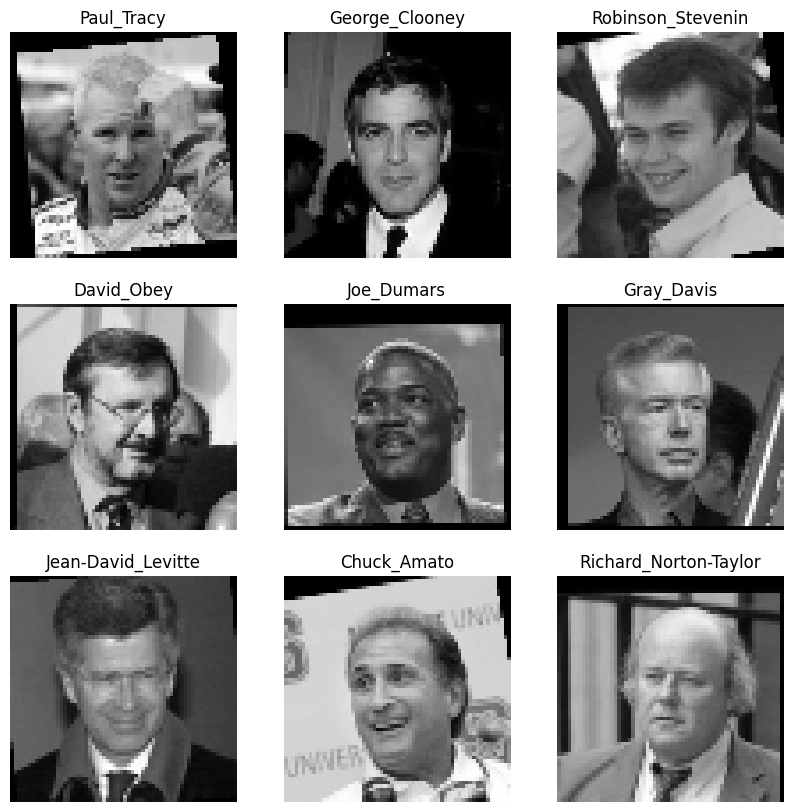

In [17]:
# Gray scale
def gray_scale(images):
    gray_images = [cv2.cvtColor(image, cv2.COLOR_RGB2GRAY) for image in images]
    return np.array(gray_images)

gray_images = gray_scale(resized_images)

display_random_images(gray_images, dataset['target'], 3, 3, cmap='gray')

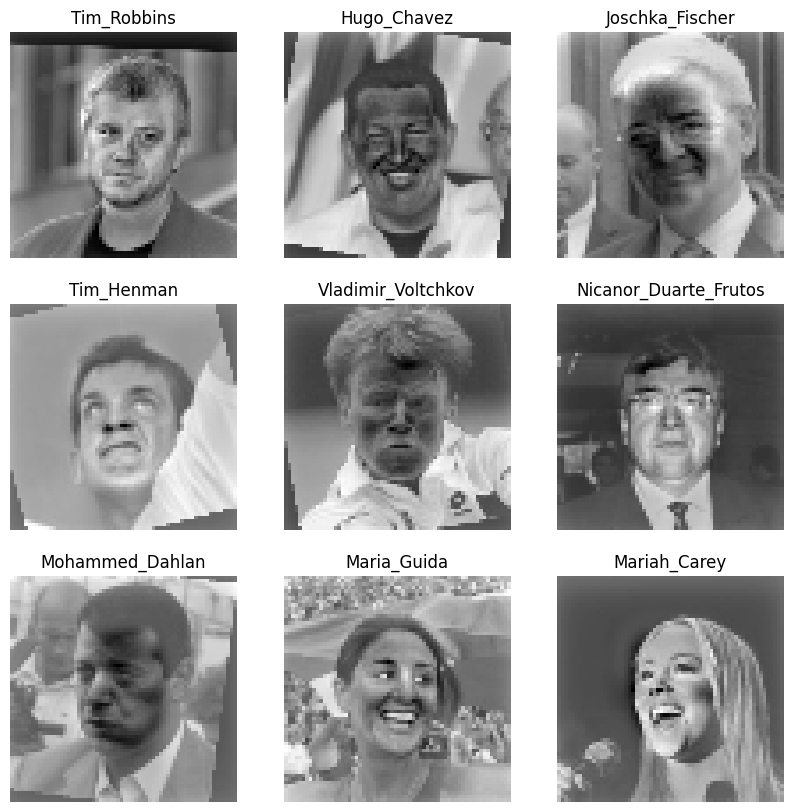

In [19]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaled_images = scaler.fit_transform(gray_images.reshape(-1, 64 * 64)).reshape(-1, 64, 64)


display_random_images(scaled_images, dataset['target'], 3, 3, cmap='gray')

## Feature Extractions

#### Filter Dataset

In [20]:
def filter_dataset(dataset, min_faces_per_person):
    # Count the number of images for each person
    target_counts = Counter(dataset['target'])

    # Initialize the filtered dataset
    filtered_dataset = {
        'data': [],
        'target': [],
        'target_names': set()
    }

    # For each image and its corresponding label
    for image, label in zip(dataset['data'], dataset['target']):
        # If this person has at least min_faces_per_person images
        if target_counts[label] >= min_faces_per_person:
            # Add this image and label to the filtered dataset
            filtered_dataset['data'].append(image)
            filtered_dataset['target'].append(label)
            filtered_dataset['target_names'].add(label)

    filtered_dataset['data'] = np.array(filtered_dataset['data'])
    filtered_dataset['target'] = np.array(filtered_dataset['target'])
    filtered_dataset['target_names'] = np.array(list(filtered_dataset['target_names']))

    return filtered_dataset

dataset['data'] = scaled_images

filtered_dataset = filter_dataset(dataset, min_faces_per_person=20)

In [21]:
filtered_dataset['data'].shape
filtered_dataset['target'].shape


print("Shape of images:", filtered_dataset['data'].shape)

Shape of images: (3023, 64, 64)


### TRAIN-TEST-SPLIT

In [43]:
X = filtered_dataset['data']
y = filtered_dataset['target']

X = X.reshape(X.shape[0], -1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42, shuffle=True)

print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)

print("Shape of y_train:", y_train.shape)
print("Shape of y_test:", y_test.shape)

Shape of X_train: (2418, 4096)
Shape of X_test: (605, 4096)
Shape of y_train: (2418,)
Shape of y_test: (605,)


#### Principal Component Analysis (PCA):

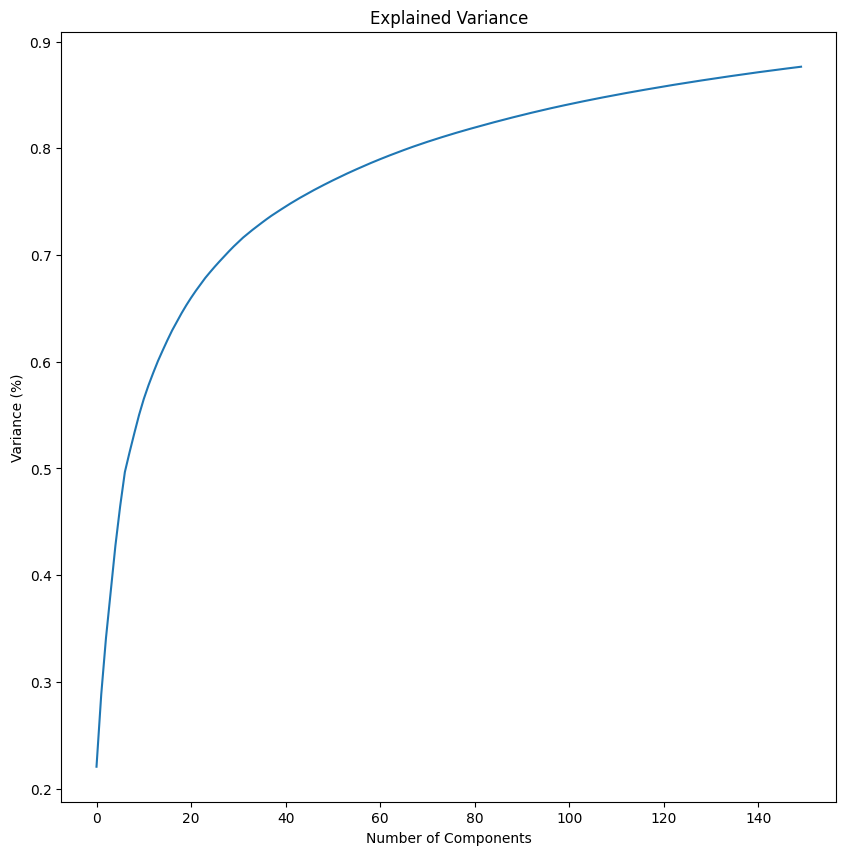

In [44]:
def pca_transform(X_train, X_test, n_components=None):
    pca = PCA(n_components=n_components, svd_solver='randomized', whiten=True).fit(X_train)
    X_train_pca = pca.transform(X_train)
    X_test_pca = pca.transform(X_test)
    return X_train_pca, X_test_pca, pca


X_train_pca, X_test_pca, pca = pca_transform(X_train, X_test, n_components=150)

# Function to plot the explained variance ratio
plt.figure(figsize=(10, 10))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)')
plt.title('Explained Variance')
plt.show()

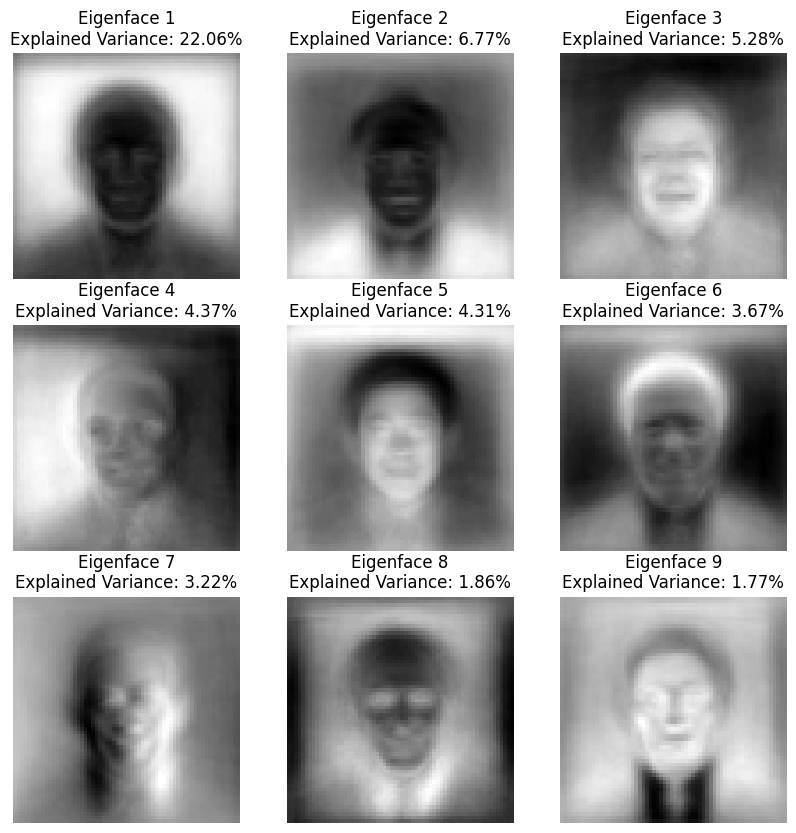

In [45]:
# Assuming pca is your PCA object and X_train is your training data
# Calculate explained variance ratio for each component
explained_variance_ratio = pca.explained_variance_ratio_

# Plot the eigenfaces with information in the title
def plot_eigenfaces(components, h, w, rows, cols, explained_variance_ratio):
    plt.figure(figsize=(10, 10))

    for i in range(rows * cols):
        plt.subplot(rows, cols, i + 1)
        plt.imshow(components[i].reshape((h, w)), cmap='gray')
        plt.title(f'Eigenface {i + 1}\nExplained Variance: {explained_variance_ratio[i]*100:.2f}%')
        plt.axis('off')

    plt.show()

# Assuming your images have dimensions 80x80, adjust as needed
plot_eigenfaces(pca.components_, 64, 64, 3, 3, explained_variance_ratio)

#### PCA with SVM

In [48]:
model = SVC(kernel='rbf',  C=1000, gamma=0.001, random_state=42, class_weight='balanced')
# Train the model
model.fit(X_train_pca, y_train)

# Make predictions
y_pred = model.predict(X_test_pca)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print("SVM Model Accuracy: {}".format(accuracy * 100))

SVM Model Accuracy: 57.02479338842975


In [49]:
# save model
from joblib import dump

# Assuming svm_model is your trained SVM model
# Replace 'svm_model.joblib' with the desired file name/path
dump(model, 'svm_model.joblib')


['svm_model.joblib']

In [50]:
from joblib import load

# Load the saved model
loaded_model = load('svm_model.joblib')


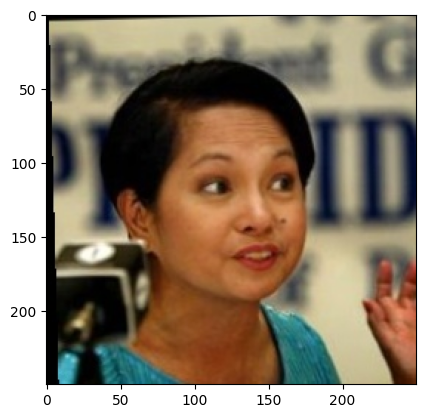

In [60]:
# display an image with its label
first_image = plt.imread('./Data/Gloria_Macapagal_Arroyo/Gloria_Macapagal_Arroyo_0013.jpg')


plt.imshow(first_image)
plt.show()

In [72]:
test_image = plt.imread('./Data/Gloria_Macapagal_Arroyo/Gloria_Macapagal_Arroyo_0013.jpg')

test_image = resize_image([test_image], target_size=(64, 64))[0]
test_image = gray_scale([test_image])[0]
test_image = scaler.transform(test_image.reshape(1, -1))
test_image = pca.transform(test_image)
pred = loaded_model.predict(test_image)[0]
print("Prediction:", pred)

Prediction: George_W_Bush


In [73]:
import streamlit as st

# Function to preprocess and extract features from an image
def preprocess_and_extract_features(test_image):
    # Implement your image preprocessing and feature extraction logic
    test_image = resize_image([test_image], target_size=(64, 64))[0]
    test_image = gray_scale([test_image])[0]
    test_image = scaler.transform(test_image.reshape(1, -1))
    test_image = pca.transform(test_image)
    return test_image

# Streamlit app
def main():
    st.title("SVM Image Classifier")

    # File uploader for user to upload an image
    uploaded_file = st.file_uploader("Choose an image...", type=["jpg", "jpeg", "png"])

    if uploaded_file is not None:
        # Display the uploaded image
        st.image(uploaded_file, caption="Uploaded Image.", use_column_width=True)

        # Preprocess and extract features from the uploaded image
        features = preprocess_and_extract_features(uploaded_file)

        # Make predictions using the loaded SVM model
        prediction = loaded_model.predict(features)[0]

        # Display the prediction result
        st.subheader(f"Prediction: {prediction}")

if __name__ == '__main__':
    main()


2023-11-22 20:29:43.932 
  command:

    streamlit run d:\Python310\lib\site-packages\ipykernel_launcher.py [ARGUMENTS]
